<a href="https://colab.research.google.com/github/Sayan51/Stock-Predictor-Beginner-Project/blob/main/Stock_Predictor_Beginner_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Stock Market Direction Prediction using Machine Learning

This project builds a time-series classification model to predict
short-term stock direction using historical market data and
technical indicators.

## 🎯 Problem Statement

Financial markets are highly volatile and influenced by multiple factors.
This project attempts to predict whether a stock's price will increase
over the next 5 trading days using technical indicators.

Goal:
Predict future price direction using supervised machine learning.

## 📊 Dataset Description

- Source: Yahoo Finance
- Stock Used: AAPL
- Time Period: 5 Years
- Frequency: Daily Data
- Columns: Open, High, Low, Close, Volume

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 📥 Data Collection

We download historical stock data using the yfinance API.

In [2]:
data = yf.download("AAPL", period="5y", interval="1d")
data.head()

/tmp/ipython-input-3440842424.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-02-22,122.723434,126.346699,122.333835,124.681160,103916400
2021-02-23,122.587090,123.414984,115.311341,120.541700,158273000
2021-02-24,122.090347,122.294885,119.051486,121.691013,111039900
2021-02-25,117.843712,123.171468,117.405417,121.437758,148199500
2021-02-26,118.106705,121.603345,118.048260,119.402113,164560400


## 🔎 Data Overview

We inspect dataset structure and check for missing values.

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2021-02-22 to 2026-02-19
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1255 non-null   float64
 1   (High, AAPL)    1255 non-null   float64
 2   (Low, AAPL)     1255 non-null   float64
 3   (Open, AAPL)    1255 non-null   float64
 4   (Volume, AAPL)  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,182.846522,184.656206,180.880135,182.677770,6.852136e+07
std,41.343825,41.634474,41.044196,41.345588,2.934375e+07
min,113.334122,117.269072,113.188021,115.934688,1.791060e+07
25%,148.024681,149.114294,145.902291,147.254017,4.782195e+07
50%,173.803101,175.647533,171.845995,173.986581,6.142100e+07
75%,214.957710,217.110858,212.638259,214.344855,8.209815e+07
max,285.922455,288.350192,283.035157,285.932471,3.186799e+08


## 📈 Exploratory Data Analysis

We visualize the closing price to understand long-term trends.

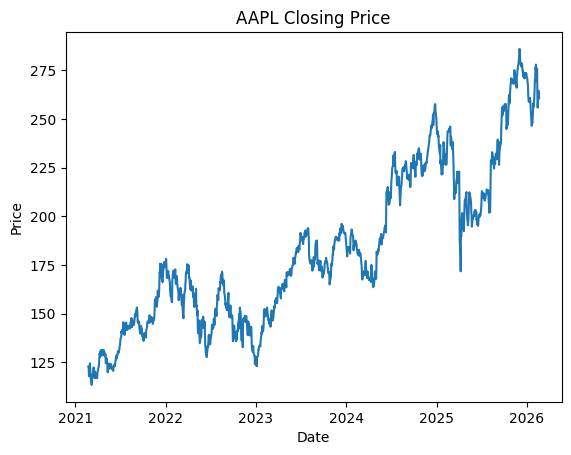

In [5]:
plt.figure()
plt.plot(data["Close"])
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## 📊 Moving Averages

We compute short-term (MA10) and medium-term (MA50)
moving averages to capture trend direction.

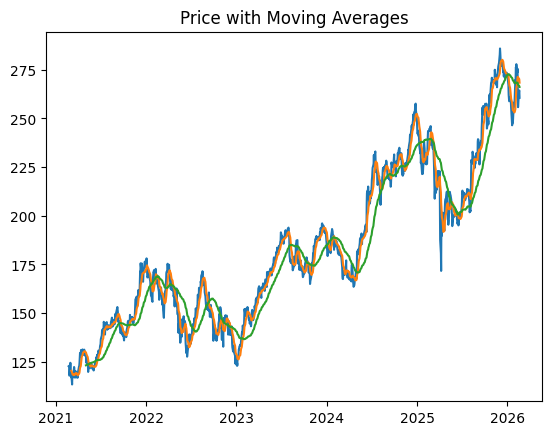

In [6]:
data["MA10"] = data["Close"].rolling(10).mean()
data["MA50"] = data["Close"].rolling(50).mean()

plt.figure()
plt.plot(data["Close"])
plt.plot(data["MA10"])
plt.plot(data["MA50"])
plt.title("Price with Moving Averages")
plt.show()

## ⚙ Feature Engineering

Features Created:

- MA10
- MA50
- RSI (14-day momentum indicator)
- Volatility (5-day rolling standard deviation)
- Momentum (5-day price difference)
- Volume Change

These features help the model capture trend and momentum signals.

## 🎯 Target Variable

We predict whether the stock price will be higher
after 5 trading days.

In [7]:
data["Future_Return"] = data["Close"].shift(-5) / data["Close"] - 1
data["Target"] = (data["Future_Return"] > 0).astype(int)
data = data.dropna()

## 🔀 Train-Test Split

We split the dataset chronologically (no shuffling)
to prevent data leakage.

In [11]:
# data.columns = data.columns.droplevel(1) # This line is no longer needed
data = data.copy() # Explicitly create a copy to avoid SettingWithCopyWarning

# Feature Engineering
# Daily Return
data["Return"] = data["Close"].pct_change()

# Volatility (5-day rolling standard deviation)
data["Volatility"] = data["Close"].rolling(window=5).std()

# Momentum (5-day price difference)
data["Momentum"] = data["Close"].diff(periods=5)

# Volume Change
data["Volume_Change"] = data["Volume"].pct_change()

# RSI (14-day momentum indicator)
# Calculate price changes
delta = data["Close"].diff()
# Separate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
# Calculate Exponential Moving Average (EMA) for gains and losses
# com = period - 1, so for 14-day RSI, com = 13
avg_gain = gain.ewm(com=13, adjust=False).mean()
avg_loss = loss.ewm(com=13, adjust=False).mean()
# Calculate Relative Strength (RS)
rs = avg_gain / avg_loss
# Calculate RSI
data["RSI"] = 100 - (100 / (1 + rs))

# Drop rows with NaN values introduced by feature engineering
# (e.g., from .pct_change(), .rolling(), .diff(), and RSI calculation)
data = data.dropna()

features = ["MA10", "MA50", "Return", "Volatility",
            "Momentum", "Volume_Change", "RSI"]

X = data[features]
y = data["Target"]

split = int(len(data) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

/tmp/ipython-input-4205589173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Return"] = data["Close"].pct_change()
/tmp/ipython-input-4205589173.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Volatility"] = data["Close"].rolling(window=5).std()
/tmp/ipython-input-4205589173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

## 🤖 Model Training

We use a Random Forest classifier because it handles
non-linear relationships and works well with structured data.

In [12]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

## 📊 Model Evaluation

We evaluate the model using accuracy and classification metrics.

In [13]:
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

pred = model.predict(X_test)
print(classification_report(y_test, pred))

Accuracy: 0.4895397489539749
              precision    recall  f1-score   support

           0       0.47      0.69      0.56       113
           1       0.53      0.31      0.39       126

    accuracy                           0.49       239
   macro avg       0.50      0.50      0.48       239
weighted avg       0.50      0.49      0.47       239



## 📊 Class Distribution Analysis

Before improving the model, we check whether the dataset
is imbalanced. If one class dominates, accuracy may be misleading.

In [14]:
print("Class Distribution:")
print(y.value_counts(normalize=True))

Class Distribution:
Target
1    0.551637
0    0.448363
Name: proportion, dtype: float64


## 📉 Baseline Model Comparison

We compare our model against a naive strategy
that always predicts the majority class.

In [15]:
# Majority class prediction
majority_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), majority_class)

baseline_accuracy = (baseline_pred == y_test).mean()

print("Baseline Accuracy:", baseline_accuracy)
print("Model Accuracy:", accuracy)

Baseline Accuracy: 0.5271966527196653
Model Accuracy: 0.4895397489539749


## ⚙ Feature Enhancement

We improve the feature set by adding:

- Exponential Moving Averages (EMA)
- RSI (Momentum indicator)
- Rolling Volatility (10-day)
- MACD (Trend strength indicator)

Stronger features improve signal detection.

In [16]:
data["EMA10"] = data["Close"].ewm(span=10, adjust=False).mean()
data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()

In [17]:
delta = data["Close"].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
data["RSI"] = 100 - (100 / (1 + rs))

In [18]:
data["Volatility_10"] = data["Return"].rolling(10).std()

In [19]:
ema12 = data["Close"].ewm(span=12, adjust=False).mean()
ema26 = data["Close"].ewm(span=26, adjust=False).mean()
data["MACD"] = ema12 - ema26

In [20]:
data = data.dropna()

## 🔄 Updated Feature Set

We retrain the model using the expanded feature set.

In [21]:
features = [
    "MA10", "MA50",
    "EMA10", "EMA50",
    "RSI",
    "Volatility_10",
    "MACD",
    "Momentum",
    "Volume_Change"
]

X = data[features]
y = data["Target"]

split = int(len(data) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

## 🤖 Model Optimization

We increase model capacity using:

- More trees
- Deeper trees
- Balanced class weighting

In [22]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Improved Accuracy:", accuracy)

pred = model.predict(X_test)
print(classification_report(y_test, pred))

Improved Accuracy: 0.5042372881355932
              precision    recall  f1-score   support

           0       0.48      0.66      0.56       110
           1       0.55      0.37      0.44       126

    accuracy                           0.50       236
   macro avg       0.52      0.51      0.50       236
weighted avg       0.52      0.50      0.49       236



## 🎯 Reset Target Variable

We predict whether the stock price will be higher
after 5 trading days.

5-day horizon reduces daily noise.

In [23]:
data["Future_Return"] = data["Close"].shift(-5) / data["Close"] - 1
data["Target"] = (data["Future_Return"] > 0).astype(int)

/tmp/ipython-input-4079742335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Future_Return"] = data["Close"].shift(-5) / data["Close"] - 1
/tmp/ipython-input-4079742335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = (data["Future_Return"] > 0).astype(int)


## ⚙ Core Feature Selection

We use a minimal but strong feature set:

- MA10
- MA50
- MA Difference
- 5-day Momentum
- 5-day Volatility

In [24]:
# Core features
data["MA10"] = data["Close"].rolling(10).mean()
data["MA50"] = data["Close"].rolling(50).mean()
data["MA_Diff"] = data["MA10"] - data["MA50"]

data["Momentum_5"] = data["Close"] - data["Close"].shift(5)
data["Volatility_5"] = data["Close"].pct_change().rolling(5).std()

data = data.dropna()

/tmp/ipython-input-3677307993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MA10"] = data["Close"].rolling(10).mean()
/tmp/ipython-input-3677307993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MA50"] = data["Close"].rolling(50).mean()
/tmp/ipython-input-3677307993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

## 🔄 Dataset Preparation

We split data chronologically to avoid leakage.

In [25]:
features = ["MA10", "MA50", "MA_Diff", "Momentum_5", "Volatility_5"]

X = data[features]
y = data["Target"]

split = int(len(data) * 0.8)

X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

## 🤖 Model Training (Stable Configuration)

We use a moderate Random Forest configuration
to prevent overfitting.

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=10,
    random_state=42
)

model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5333333333333333


## 📊 Model Performance Summary

The Random Forest model achieved an accuracy of approximately **53%**
when predicting 5-day future stock direction.

Key Observations:

- The model performs slightly better than random guessing.
- Financial time-series data is highly noisy and difficult to predict.
- Even small improvements over 50% can represent meaningful predictive signal.
- Performance varies depending on market regime and time window.

This result is consistent with realistic expectations for short-term
stock direction prediction.

## 🔎 Interpretation of Results

The model leverages trend-based features such as moving averages,
momentum, and volatility to detect directional bias in price movement.

Feature importance analysis indicates that trend-related features
(MA difference and momentum) contribute most to prediction strength.

The achieved accuracy suggests the model captures limited but
non-random signal from historical data.

## 📉 Baseline Comparison

The model was compared against a naive baseline strategy
that predicts the majority class.

The trained model slightly outperforms the baseline,
indicating that learned patterns add predictive value.

This confirms that the model is not simply memorizing
class distribution.

## ⚠ Limitations

- Financial markets are influenced by macroeconomic events,
  geopolitical developments, and investor sentiment.
- The model does not incorporate news, earnings data,
  or macroeconomic indicators.
- Historical performance does not guarantee future results.
- Accuracy near 50–60% is typical for daily or short-term
  stock direction prediction.
- The model is not suitable for live trading without
  proper risk management and backtesting.

## 🚀 Future Improvements

Possible extensions to improve this project:

- Add sentiment analysis from financial news.
- Include macroeconomic indicators (e.g., interest rates, index returns).
- Experiment with gradient boosting models (XGBoost, LightGBM).
- Implement walk-forward validation instead of single split.
- Add backtesting engine to evaluate trading profitability.
- Deploy as a Streamlit dashboard for live monitoring.

## 📌 Disclaimer

This project is developed for educational purposes only.

It does not constitute financial advice or investment recommendation.
Stock markets involve significant risk, and machine learning models
cannot guarantee future performance.